In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Install PyTorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torchtext
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57c0c000 @  0x7f17fbd512a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 71kB 6.0MB/s 


In [0]:
# Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GPU
device = torch.device('cuda')

# Load and clean data

In [0]:
# Download data
legitimate_URLs = np.load("/content/gdrive/My Drive/legitimate_URLs.npy")
legitimate_URLs = np.concatenate((legitimate_URLs,np.load("/content/gdrive/My Drive/legitimate_URLs2.npy")))
phishing_URLs = np.load("/content/gdrive/My Drive/phishing_URLs.npy")
phishing_URLs = np.concatenate((phishing_URLs,np.load("/content/gdrive/My Drive/phishing_URLs2.npy")))
# randomly permute URLs
np.random.seed(0)
legitimate_URLs = list(legitimate_URLs[np.random.permutation(len(legitimate_URLs))])
phishing_URLs = list(phishing_URLs[np.random.permutation(len(phishing_URLs))])
# clean URLs
legitimate_URLs = [l.split('http://')[-1].split('www.')[-1].split('https://')[-1] for l in legitimate_URLs]
phishing_URLs = [p.split('http://')[-1].split('www.')[-1].split('https://')[-1] for p in phishing_URLs]
phishing_URLs = list(set(phishing_URLs) - set(legitimate_URLs))

In [0]:
len(legitimate_URLs), len(phishing_URLs)

# phishing URL list a bit small

(191233, 11570)

In [0]:
# map to numbers
letters = ''.join(legitimate_URLs+phishing_URLs)
from collections import Counter
c = Counter(letters)
d = {}
for i, (l, _) in enumerate(c.most_common(128)):
    d[l] = i + 1

In [0]:
# training set: all keys plus non-keys
# testing set: remaining non-keys 
training_list = legitimate_URLs[:int(len(legitimate_URLs)/2)]+phishing_URLs
testing_list = legitimate_URLs[int(len(legitimate_URLs)/2):]
    
# cut off at 150 chars
char_cutoff = 150
X_train = torch.tensor([[d.get(l,0) for l in url[:min([len(url),char_cutoff])]]+[0 for l in range(char_cutoff-len(url))] 
                        for url in training_list])
y_train = torch.tensor([0]*int(len(legitimate_URLs)/2)+[1]*int(len(phishing_URLs)))

X_test = torch.tensor([[d.get(l,0) for l in url[:min([len(url),char_cutoff])]]+[0 for l in range(char_cutoff-len(url))] 
                        for url in testing_list])
y_test = torch.tensor([0]*(len(testing_list)))

In [0]:
# Batch data
def make_batch_train(X_t, y_t, B):
  sample = torch.randint(0, X_t.shape[0], [B]).long()
  batch_X0 = torch.stack([X_t[s] for s in sample])
  batch_X = batch_X0.to(device)
  batch_y0 = torch.stack([y_t[s]*torch.ones(len(X_t[s])).long() for s in sample]).to(device)
  batch_y = batch_y0.to(device)
  return batch_X, batch_y
  
def make_batch_test(X_t, y_t, B):
  sample = torch.randint(0, X_t.shape[0], [B]).long()
  batch_X0 = torch.stack([X_t[s] for s in sample])
  batch_X = batch_X0.to(device)
  batch_y0 = torch.stack([y_t[s] for s in sample]).to(device)
  batch_y = batch_y0.to(device)
  return batch_X, batch_y

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size=150, output_size=2, emb_size=128, h_size=128, layers=1, dropout=0.3):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, emb_size)
        self.rnn = nn.GRU(emb_size, h_size, num_layers=layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(h_size, output_size)
        
    def forward(self, x, h=None):
        x = self.embedding(x)
        x, h = self.rnn(x, h)
        x = self.linear(x)
        return x, h

In [0]:
def val(model, X_t, y_t):
    model.eval()
    with torch.no_grad():
        total = 0
        total_right = 0
        total_loss = 0
        for batch in range(50):
            x, y = make_batch_test(X_t, y_t, 256)
            y_hat, _ = model(x)
            #optimizer.zero_grad()
            preds = y_hat.max(dim=2)[1][:,149]
            preds_eq = preds.eq(y)
            total_right += preds_eq.sum().item()
            total += preds_eq.numel()
            loss = criterion(y_hat[:,149].view(-1,2), y.view(-1).long()).detach().item()
            total_loss += loss
    return total_right / total, total_loss / 50

In [0]:
def train(model):
    model.train()
    total_loss = 0
    for batch in range(50):
        x, y = make_batch_train(X_train, y_train, 256)
        y_hat, _ = model(x)
        optimizer.zero_grad()
        y_hat = y_hat.view(-1,2)
        y = y.view(-1).long()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    total_loss += loss.item()
    return total_loss / 50

In [0]:
emb_size=5
h_sizes = [16,8,4]
layers = 1
criterion = nn.CrossEntropyLoss()
loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/simulations/"
plot_loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/plots/"

# Train (don't need to run this)

In [0]:
models = {}
for i in range(3):
  h_size = h_sizes[i]
  # Create model, loss function, optimizer
  models[i] = RNN(emb_size=emb_size, h_size=h_size, layers=layers).to(device)
  optimizer = torch.optim.Adamax(models[i].parameters())

  # Train and validate
  start = time.time()
  for epoch in range(30):
      train_loss = train(models[i])
      val_acc, val_loss = val(models[i],X_train, y_train)
      if(epoch%10 == 0):
        print('[E{:4d}] Loss: {:.4f} | Acc: {:.4f}'.format(epoch, val_loss, val_acc))
  end = time.time()
  print(end-start)
  torch.save(models[i].state_dict(), loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size))  

[E   0] Loss: 0.3463 | Acc: 0.8901
[E  10] Loss: 0.3037 | Acc: 0.8941
[E  20] Loss: 0.2079 | Acc: 0.9237
93.85430550575256
[E   0] Loss: 0.3458 | Acc: 0.8936
[E  10] Loss: 0.3413 | Acc: 0.8925
[E  20] Loss: 0.3324 | Acc: 0.8938
122.24123215675354
[E   0] Loss: 0.3811 | Acc: 0.8921
[E  10] Loss: 0.3354 | Acc: 0.8951
[E  20] Loss: 0.3394 | Acc: 0.8925
106.56146216392517


# Load trained RNNs and evaluate (change paths)

In [0]:
# sizes of RNN models
models = {}
model_sizes = {}
for i,h_size in enumerate(h_sizes):
  print("hidden size", h_size)
  model_sizes[i] = os.path.getsize(loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size))
  print("model size (bytes)", model_sizes[i])
  models[i] = RNN(emb_size=emb_size, h_size=h_size, layers=layers).to(device)
  models[i].load_state_dict(torch.load(loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size)))
  models[i].eval()
  print(val(models[i], X_test,y_test))
  
  avg_time = 0
  for t in range(100):
    x,y = make_batch_test(X_test, y_test,1)
    start = time.time()
    models[i](x)
    total = time.time()-start
    avg_time += total
  avg_time /= 100
  print("time to evaluate", avg_time)
  print("="*30)

hidden size 16
model size (bytes) 8666
(0.993984375, 0.04757724568247795)
time to evaluate 0.006016991138458252
hidden size 8
model size (bytes) 5624
(0.979296875, 0.09601368442177773)
time to evaluate 0.0060491180419921875
hidden size 4
model size (bytes) 4676
(0.999921875, 0.09370115146040917)
time to evaluate 0.005935673713684082


# Bloom Filter Class

In [0]:
!pip install mmh3
!pip install bitarray

  Running setup.py bdist_wheel for mmh3 ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/38/b4/ea/6e4e321c625d3320c0c496bf4088371546d8fce5f1dd71b219
Successfully built mmh3
  Running setup.py bdist_wheel for bitarray ... - \ done
  Stored in directory: /root/.cache/pip/wheels/5f/33/3c/1370189fedb8fbb2c3297388cc8cdbe2af0efb48941cf8d526
Successfully built bitarray


In [0]:
import mmh3
import math
import torch
from bitarray import bitarray 

class BloomFilter(object): 
  
    def __init__(self, items_count,fp_prob): 
        ''' 
        items_count : int 
            Number of items expected to be stored in bloom filter 
        fp_prob : float 
            False Positive probability in decimal 
        '''
        # False posible probability in decimal 
        self.fp_prob = fp_prob 
  
        # Size of bit array to use 
        self.size = self.get_size(items_count,fp_prob) 
  
        # number of hash functions to use 
        self.hash_count = self.get_hash_count(self.size,items_count) 
  
        # Bit array of given size 
        self.bit_array = bitarray(self.size) 
  
        # initialize all bits as 0 
        self.bit_array.setall(0) 
  
    def add(self, item): 
        ''' 
        Add an item in the filter 
        '''
        digests = [] 
        for i in range(self.hash_count): 
            # i works as seed to mmh3.hash() function 
            digest = mmh3.hash(item,i) % self.size 
            digests.append(digest) 
  
            # set the bit True in bit_array 
            self.bit_array[digest] = True
  
    def check(self, item): 
        ''' 
        Check for existence of an item in filter 
        '''
        for i in range(self.hash_count): 
            digest = mmh3.hash(item,i) % self.size 
            if self.bit_array[digest] == False: 
  
                # if any of bit is False then,its not present 
                # in filter 
                # else there is probability that it exist 
                return False
        return True
  
    @classmethod
    def get_size(self,n,p): 
        ''' 
        Return the size of bit array(m) to used using 
        following formula 
        m = -(n * lg(p)) / (lg(2)^2) 
        n : int 
            number of items expected to be stored in filter 
        p : float 
            False Positive probability in decimal 
        '''
        m = -(n * math.log(p))/(math.log(2)**2) 
        return int(m) 
  
    @classmethod
    def get_hash_count(self, m, n): 
        ''' 
        Return the hash function(k) to be used using 
        following formula 
        k = (m/n) * lg(2) 
  
        m : int 
            size of bit array 
        n : int 
            number of items expected to be stored in filter 
        '''
        k = (m/n) * math.log(2) 
        return int(k)

# BF

In [0]:
def run_BF(FPR):
  BF = BloomFilter(len(phishing_URLs), FPR)
  for url in phishing_URLs:
    BF.add(url)
  
  
  fps = 0
  total = 0
  total_time = 0
  for url in testing_list:
    total += 1
    start = time.time()
    result = BF.check(url)
    end = time.time()
    total_time += (end-start)
    if result == True:
      fps += 1
  
  avg_fp = fps/total

  # returns empirical FPR, BF size in bytes, and access time per element
  return avg_fp, BF.size/8, (total_time)/len(testing_list)

In [0]:
FPR, BF_size, t = run_BF(0.02)
print("FPR", FPR, "size", BF_size, "time", t)
BF = {"FPR": FPR, "size": BF_size, "time": t}
np.save(loc+"BF", BF)

FPR 0.02166978675340159 size 11775.875 time 1.644546363728673e-06


In [0]:
BF_sizes = {}
for fpr in fprs:
  BF = BloomFilter(len(phishing_URLs), fpr)
  BF_sizes[fpr] = BF.size / 8
  
print(BF_sizes)

{0.001: 20793.5, 0.005: 15948.875, 0.01: 13862.375, 0.02: 11775.875}


# Classifier

In [0]:
def get_classifier_probs(model):
  probs1 = []
  probs0 = []
  for i in range(int(len(y_train)/100)+1):
    x0 = torch.stack([X_train[s] for s in range(100*i, min(100*(i+1), len(y_train)))])
    x = x0.to(device)
    y0 = torch.stack([y_train[s] for s in range(100*i, min(100*(i+1), len(y_train)))])
    y = y0.to(device)  
    y_hat, _ = model(x)
    ps = torch.sigmoid(y_hat[:,:,1])[:,149]
    probs1 += list(ps[y==1].squeeze().detach().cpu().numpy())
    probs0 += list(ps[y==0].squeeze().detach().cpu().numpy())
  return probs1, probs0

In [0]:
# probs = {}
# urls = {}
# probs[0] = get_classifier_probs(models[0])
# probs[1] = get_classifier_probs(models[1])
# probs[2] = get_classifier_probs(models[2])

In [0]:
# sns.distplot(probs[0], label = "GRU, 128 dimensions")
# sns.distplot(probs[1], label = "GRU, 32 dimensions")
# sns.distplot(probs[2], label = "GRU, 16 dimensions")
# plt.title("Distribution of classifier output probabilities for non-keys")
# plt.legend()
# plt.show()

In [0]:
def determine_tau(FPR_tau, prob_list):
  return np.percentile(np.array(prob_list),100*(1.-FPR_tau))

# LBF

In [0]:
def build_LBF_classifier(model,FPR_tau):
  probs1, probs0 = get_classifier_probs(model)
  tau = determine_tau(FPR_tau,probs0)
  false_negs = []
  for i,url in enumerate(phishing_URLs):
    if(probs1[i] < tau):
      false_negs += [url]
  return false_negs, tau

In [0]:
def build_LBF_backup(false_negs, FPR, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B = (FPR-FPR_tau)/(1-FPR_tau)
  if(FPR_B <= 0):
    return "error"
  LBF_backup = BloomFilter(num_false_negs, FPR_B)
  for url in false_negs:
    LBF_backup.add(url)
  return LBF_backup

In [0]:
def test_LBF(model, LBF_backup, tau):
  # test on testing data
  fps = 0
  total = 0
  total_time = 0
  for i in range(int(len(y_test)/100)+1):
    x0 = torch.stack([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
    x = x0.to(device)
    y0 = torch.stack([y_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
    y = y0.to(device)  
    total += len(y)
    
    start = time.time()
    y_hat, _ = model(x)
    ps = torch.sigmoid(y_hat[:,:,1])[:,149].squeeze().detach().cpu().numpy()
    for ix, p in enumerate(ps):
      if(p > tau):
        result = True        
      else:
        result = LBF_backup.check(testing_list[100*i+ix])
      if(result):
        fps += 1
    end = time.time()
    total_time += (end-start)

  avg_fp = fps/total
  
  # returns empirical FPR, BF size, and avg access time
  return avg_fp, LBF_backup.size / 8, (total_time)/len(y_test)

# SBF.py equivalent

In [0]:
def build_SLBF_initial(false_negs, FPR, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B0 = FPR/FPR_tau*(1.-num_false_negs/len(phishing_URLs))
  if(FPR_B0 <= 0 or FPR_B0 >= 1):
    return "error"
  SLBF_initial = BloomFilter(len(phishing_URLs), FPR_B0)
  for url in phishing_URLs:
    SLBF_initial.add(url)
  return SLBF_initial

In [0]:
def build_SLBF_backup(false_negs, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B = FPR_tau/((1-FPR_tau)*(len(phishing_URLs)/num_false_negs - 1))
  if(FPR_B <= 0):
    return "error"
  SLBF_backup = BloomFilter(num_false_negs, FPR_B)
  for url in false_negs:
    SLBF_backup.add(url)
  return SLBF_backup

In [0]:
def test_SLBF(SLBF_initial, model, SLBF_backup, tau):
  # test on testing data
  fps = 0
  total = 0
  total_time = 0
  for i in range(int(len(y_test)/100)+1):
    x0 = torch.stack([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
    x = x0.to(device)
    y0 = torch.stack([y_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
    y = y0.to(device)  
    total += len(y)
    
    start = time.time()
    y_hat, _ = model(x)
    ps = torch.sigmoid(y_hat[:,:,1])[:,149].squeeze().detach().cpu().numpy()
    for ix, p in enumerate(ps):
      result = SLBF_initial.check(testing_list[100*i+ix])
      if(result):
        if(p>tau):
          result = True
        else:
          result = SLBF_backup.check(testing_list[100*i+ix])
      if(result):
        fps += 1
    end = time.time()
    total_time += (end-start)

  avg_fp = fps/total
  
  # returns empirical FPR, BF size, and avg access time
  return avg_fp, (SLBF_initial.size+SLBF_backup.size) / 8, (total_time)/len(y_test)

# $\tau$ analysis for LBF

In [0]:
fprs = [0.001,0.005,0.01,0.02]
fpr_ratios = [0.1*i for i in range(1,11)]
false_negs = {}
taus = {}
for i in range(3):
  false_negs[i] = {}
  taus[i] = {}
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      false_negs[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)] = build_LBF_classifier(models[i], fpr*fpr_ratio)
      print(len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)])

0.9739844425237684 0.768336955070491
0.9423509075194468 0.7601787717938461
0.9248055315471045 0.7556438425779307
0.91495246326707 0.752091467738152
0.8891961970613655 0.7430379012227105
0.8790838375108038 0.7383372384309723
0.8657735522904062 0.7327593480944624
0.8432152117545376 0.7199571111202261
0.8307692307692308 0.7119419878721297
0.8180639585133967 0.7020724827051188
0.8891961970613655 0.7430379012227105
0.8180639585133967 0.7020724827051188
0.7826274848746759 0.6687090955674648
0.7395851339671564 0.6206340336799692
0.7218668971477961 0.5959508910775231
0.7056179775280899 0.5754335978627197
0.6865168539325842 0.5504393991827983
0.680466724286949 0.5414081406593316
0.670181503889369 0.52859745025636
0.6623163353500432 0.5175028517842295
0.8180639585133967 0.7020724827051188
0.7395851339671564 0.6206340336799692
0.7056179775280899 0.5754335978627197
0.680466724286949 0.5414081406593316
0.6623163353500432 0.5175028517842295
0.6445980985306828 0.49808899015188407
0.6262748487467589 0

In [0]:
np.save(loc+"false_negs", false_negs)
np.save(loc+"taus", taus)

In [0]:
LBF_backups = {}
for i in range(3):
  LBF_backups[i] = {}
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:#
      LBF_backups[i][(fpr,fpr_ratio)] = build_LBF_backup(false_negs[i][(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
      if(LBF_backups[i][(fpr,fpr_ratio)] =='error'):
        continue
      fpr0, BF_size, t = test_LBF(models[i], LBF_backups[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)])
      print(fpr, fpr0, BF_size, t)
      LBF = {"FPR": fpr0, "size": BF_size+model_sizes[i], "time": t}
      np.save(loc+"LBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), LBF)

0.001 0.0009098800422519008 20561.125 0.00012543191547438284
0.001 0.0007111706077371179 20227.25 0.00012240827059276267
0.001 0.0009517136074129077 20222.0 0.00012625399665868825
0.001 0.0009098800422519008 20430.875 0.00012604719533993795
0.001 0.0014641747806352426 20343.5 0.00012660770603170637
0.001 0.00102492234644467 20702.375 0.0001255127339793123
0.001 0.0010772143028959286 21138.375 0.00012654253408109112
0.001 0.0011295062593471871 21616.5 0.0001242488564380432
0.001 0.001255006954830208 23030.625 0.00012447871491818688
0.005 0.004601692167710763 14462.25 0.0001244083665139053
0.005 0.007373165859627472 13594.125 0.00012424259282936795
0.005 0.004737651254484035 13318.75 0.00012380301566496837
0.005 0.005145528514803853 12928.25 0.00012506430747287906
0.005 0.005291945992867377 13013.625 0.00012468258391058282
0.005 0.005093236558352594 13193.625 0.00012407563973125437
0.005 0.005176903688674608 13429.875 0.00012398807637701496
0.005 0.005448821862221153 14141.125 0.00012528

In [0]:
fnrs = {}
for i in range(3):
  fnrs[i] = pd.DataFrame(index=fpr_ratios, columns=fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      fnrs[i].loc[fpr_ratio,fpr] = len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs)

In [0]:
true_fpr_LBF = {}
sizes_LBF = {}
times_LBF = {}
for i in range(3):
  true_fpr_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  sizes_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  times_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF = np.load(loc+"LBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy").item()
        true_fpr_LBF[i].loc[fpr_ratio,fpr] = LBF['FPR']
        sizes_LBF[i].loc[fpr_ratio,fpr] = LBF['size']
        times_LBF[i].loc[fpr_ratio,fpr] = LBF['time']
        print(LBF['FPR'], LBF['size'], LBF['time'])
      except:
        print("error")
        continue


0.0009098800422519008 29227.125 0.00012543191547438284
0.0007111706077371179 28893.25 0.00012240827059276267
0.0009517136074129077 28888.0 0.00012625399665868825
0.0009098800422519008 29096.875 0.00012604719533993795
0.0014641747806352426 29009.5 0.00012660770603170637
0.00102492234644467 29368.375 0.0001255127339793123
0.0010772143028959286 29804.375 0.00012654253408109112
0.0011295062593471871 30282.5 0.0001242488564380432
0.001255006954830208 31696.625 0.00012447871491818688
error
0.004601692167710763 23128.25 0.0001244083665139053
0.007373165859627472 22260.125 0.00012424259282936795
0.004737651254484035 21984.75 0.00012380301566496837
0.005145528514803853 21594.25 0.00012506430747287906
0.005291945992867377 21679.625 0.00012468258391058282
0.005093236558352594 21859.625 0.00012407563973125437
0.005176903688674608 22095.875 0.00012398807637701496
0.005448821862221153 22807.125 0.0001252843915318416
0.005354696340608887 23990.625 0.0001232618169354571
error
0.010040055638641665 2026

In [0]:
plot_loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/plots/"

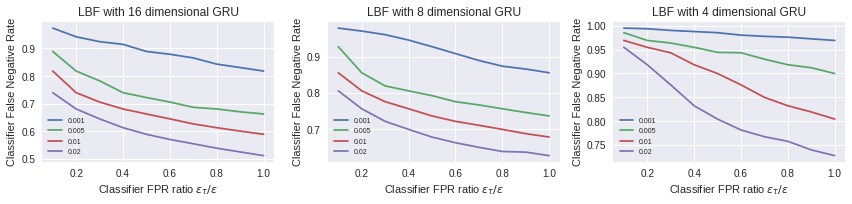

In [0]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  fnrs[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Classifier False Negative Rate")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_classifier_FNR.png")
# FPR_tau/FPR forced to stay between 0 and 1, 

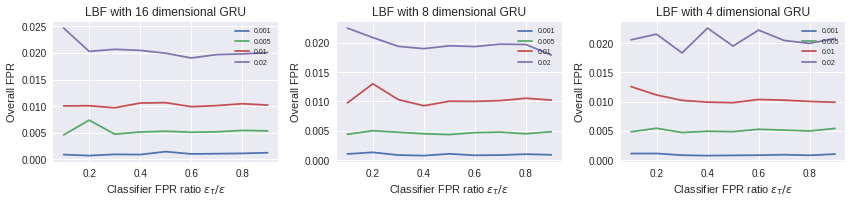

In [0]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  true_fpr_LBF[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Overall FPR")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small', loc='upper right')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_fpr.png")
#regardless of what the desired FPR is, the curve looks the same??

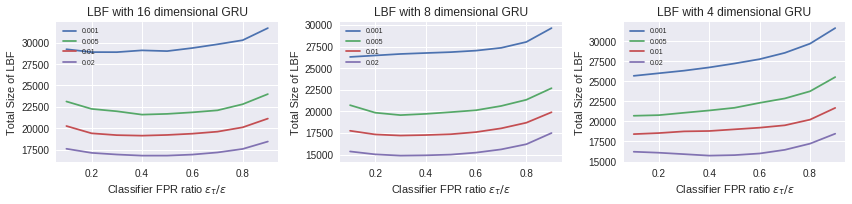

In [0]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  sizes_LBF[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Total Size of LBF")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small', loc='upper left')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_size.png")
# seems most optimal at 0.5

# $\tau$ analysis for SLBF

In [0]:
fpr_ratios2 = [1.*i for i in range(1,11)]
for i in range(3):
  for fpr in fprs:
    for fpr_ratio in fpr_ratios2:
      false_negs[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)] = build_LBF_classifier(models[i], fpr*fpr_ratio)
      print(len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)])

0.8180639585133967 0.7020724827051188
0.7395851339671564 0.6206340336799692
0.7056179775280899 0.5754335978627197
0.680466724286949 0.5414081406593316
0.6623163353500432 0.5175028517842295
0.6445980985306828 0.49808899015188407
0.6262748487467589 0.47742681846022494
0.6125324114088159 0.4632381570339203
0.6001728608470182 0.45183430910110434
0.5885911840968021 0.4393618702888489
0.6623163353500432 0.5175028517842295
0.5885911840968021 0.4393618702888489
0.545894554883319 0.396639709174633
0.5112359550561798 0.3683811187744139
0.47994814174589456 0.346376933157444
0.45073465859982714 0.3276238515973091
0.4222990492653414 0.3122225917875766
0.4024200518582541 0.3019768893718719
0.38133102852203976 0.2909032642841339
0.37536732929991357 0.28748245537281036
0.5885911840968021 0.4393618702888489
0.5112359550561798 0.3683811187744139
0.45073465859982714 0.3276238515973091
0.4024200518582541 0.3019768893718719
0.37536732929991357 0.28748245537281036
0.33465859982713914 0.27027056813239997
0.3

In [0]:
np.save(loc+"false_negs2", false_negs)
np.save(loc+"taus2", taus)

In [0]:
SLBF_initials = {}
SLBF_backups = {}
for i in range(3):
  SLBF_initials[i] = {}
  SLBF_backups[i] = {}
  for fpr, fpr_ratio in false_negs[i].keys():
    c=(1.-len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs))
    if(fpr_ratio < c or fpr*fpr_ratio > c):
      print(fpr_ratio, fpr, "bad fpr_tau")
      continue
    SLBF_initials[i][(fpr,fpr_ratio)] = build_SLBF_initial(false_negs[i][(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
    SLBF_backups[i][(fpr,fpr_ratio)] = build_SLBF_backup(false_negs[i][(fpr,fpr_ratio)], fpr*fpr_ratio)
    if(SLBF_backups[i][(fpr,fpr_ratio)] =='error' or SLBF_initials[i][(fpr,fpr_ratio)]=='error'):
      continue
    fpr0, BF_size, t = test_SLBF(SLBF_initials[i][(fpr,fpr_ratio)], models[i], SLBF_backups[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)])
    print(fpr, fpr0, BF_size, t)
    SLBF = {"FPR": fpr0, "size": BF_size+model_sizes[i], "time": t}
    np.save(loc+"SLBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), SLBF)

# for fpr, fpr_ratio in false_negs2.keys():
#   c=(1.-len(false_negs2[(fpr,fpr_ratio)])/len(phishing_URLs))
#   if(fpr_ratio < c or fpr*fpr_ratio > c):
#     print(fpr_ratio, fpr, "bad fpr_tau")
#     continue
#   SLBF_keys += [(fpr,fpr_ratio)]
#   SLBF_initials[(fpr,fpr_ratio)] = build_SLBF_initial(false_negs2[(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
#   SLBF_backups[(fpr,fpr_ratio)] = build_SLBF_backup(false_negs2[(fpr,fpr_ratio)], fpr*fpr_ratio)
#   if(SLBF_backups[(fpr,fpr_ratio)] =='error' or SLBF_initials[(fpr,fpr_ratio)]=='error'):
#     continue
#   fpr0, BF_size, t = test_SLBF(SLBF_initials[(fpr,fpr_ratio)], models[2], SLBF_backups[(fpr,fpr_ratio)], taus[(fpr,fpr_ratio)])
#   print(fpr, fpr0, BF_size, t)
#   SLBF = {"FPR": fpr0, "size": BF_size+model_sizes[2], "time": t}
#   np.save(loc+"SLBF_hid"+str(h_sizes[2])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), SLBF)

0.001 0.000899421650961649 20435.0 0.0001211437472415227
0.001 0.0009517136074129077 19978.375 0.00012171300753633311
0.001 0.0011608814332179423 19759.875 0.00012117670848478637
0.001 0.0011295062593471871 19665.125 0.00012018103158552388
0.001 0.0008157545206396352 19305.125 0.00012046508823372713
0.001 0.0006902538251566144 19201.625 0.0001215954601477306
0.001 0.0009726303899934112 19043.5 0.00012045212964523773
0.001 0.00132821569386197 18733.375 0.0001224477797008278
0.001 0.000941255216122656 18587.25 0.00012103759503271556
0.001 0.0010144639551544182 18435.75 0.00012059039282240478
0.1 0.005 bad fpr_tau
0.005 0.0064005354696340605 13591.0 0.00012472427979603977
0.005 0.006745662382212368 13266.625 0.00012849049892477602
0.005 0.007822876685108296 12799.0 0.00012490547063521057
0.005 0.009046508466067749 12706.625 0.00012589022112793842
0.005 0.004957277471579322 12619.0 0.00012379065301695405
0.005 0.004769026428354791 12477.125 0.00012378938134481056
0.005 0.005271029210286874

In [0]:
fnrs2 = {}
for i in range(3):
  fnrs2[i] = pd.DataFrame(index=fpr_ratios+fpr_ratios2, columns=fprs)
  for fpr,fpr_ratio in false_negs[i].keys():
      fnrs2[i].loc[fpr_ratio,fpr] = len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs)
#   for fpr,fpr_ratio in false_negs2.keys():
#       fnrs2[i].loc[fpr_ratio,fpr] = len(false_negs2[i][(fpr,fpr_ratio)])/len(phishing_URLs)

In [0]:
true_fpr_SLBF = {}
sizes_SLBF = {}
times_SLBF = {}
for i in range(3):
  true_fpr_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  sizes_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  times_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  for fpr,fpr_ratio in false_negs[i].keys():
    try:
      SLBF = np.load(loc+"SLBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy").item()
      true_fpr_SLBF[i].loc[fpr_ratio,fpr] = SLBF['FPR']
      sizes_SLBF[i].loc[fpr_ratio,fpr] = SLBF['size']
      times_SLBF[i].loc[fpr_ratio,fpr] = SLBF['time']
      print(SLBF['FPR'], SLBF['size'], SLBF['time'])
    except:
      print("error", fpr_ratio, fpr)
      continue

# for fpr,fpr_ratio in false_negs2.keys():
#   try:
#     SLBF = np.load(loc+"SLBF_hid"+str(h_sizes[2])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy").item()
#     true_fpr_SLBF.loc[fpr_ratio,fpr] = SLBF['FPR']
#     sizes_SLBF.loc[fpr_ratio,fpr] = SLBF['size']
#     times_SLBF.loc[fpr_ratio,fpr] = SLBF['time']
#     print(SLBF['FPR'], SLBF['size'], SLBF['time'])
#   except:
#     print("error")
#     continue


0.000899421650961649 29101.0 0.0001211437472415227
0.0009517136074129077 28644.375 0.00012171300753633311
0.0011608814332179423 28425.875 0.00012117670848478637
0.0011295062593471871 28331.125 0.00012018103158552388
0.0008157545206396352 27971.125 0.00012046508823372713
0.0006902538251566144 27867.625 0.0001215954601477306
0.0009726303899934112 27709.5 0.00012045212964523773
0.00132821569386197 27399.375 0.0001224477797008278
0.000941255216122656 27253.25 0.00012103759503271556
0.0010144639551544182 27101.75 0.00012059039282240478
error 0.1 0.005
0.0064005354696340605 22257.0 0.00012472427979603977
0.006745662382212368 21932.625 0.00012849049892477602
0.007822876685108296 21465.0 0.00012490547063521057
0.009046508466067749 21372.625 0.00012589022112793842
0.004957277471579322 21285.0 0.00012379065301695405
0.004769026428354791 21143.125 0.00012378938134481056
0.005271029210286874 21181.625 0.00012214922349671424
0.005365154731899139 21149.5 0.00012593164522464313
0.005678906470606692 2

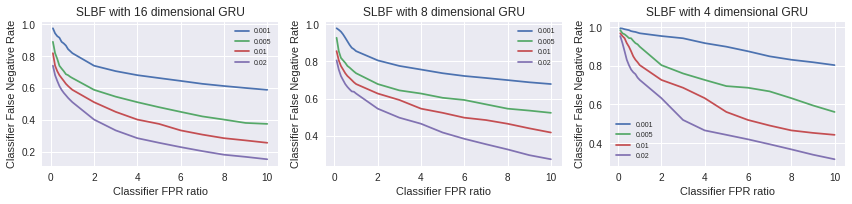

In [0]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  fnrs2[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Classifier False Negative Rate")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_classifier_FNR.png")

# FPR_tau/FPR forced to stay between 0 and 1, 

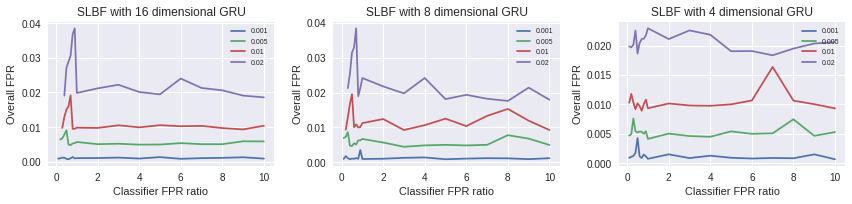

In [0]:
f,ax=plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  true_fpr_SLBF[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Overall FPR")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_fpr.png")


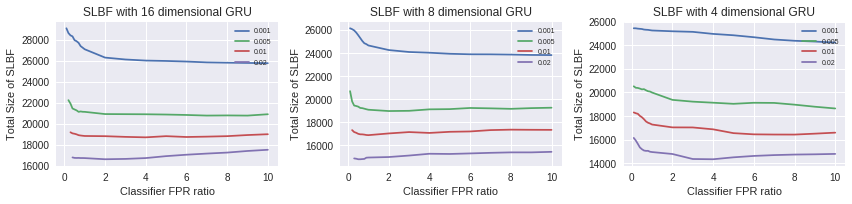

In [0]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  sizes_SLBF[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Total Size of SLBF")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_size.png")


#size is best when ratio = 1

In [0]:
true_fpr_LBF_LH = {}
sizes_LBF_LH = {}
times_LBF_LH = {}
for i in range(3):
  true_fpr_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  sizes_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  times_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF = np.load(loc+"LBF_LH_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy").item()
        true_fpr_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['FPR']
        sizes_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['size']
        times_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['time']
        print(LBF['FPR'], LBF['size'], LBF['time'])
      except:
        print("error")
        continue


0.0008471296945103905 29227.125 0.00018751961480973137
0.0008785048683811456 28893.25 0.00017938101033706527
0.0009307968248324043 28888.0 0.00018085342465553925
0.000983088781283663 29096.875 0.0001802961779222724
0.0012654653461204597 29009.5 0.0001873715472896857
0.0010353807377349216 29368.375 0.00017225916259954572
0.001181798215798446 29804.375 0.00017515984177184226
0.001223631780959453 30282.5 0.00017237103234604885
0.0012759237374107115 31696.625 0.00017248796135290316
error
0.004821318384806049 23128.25 0.0002500192935304915
0.0075405001202715 22260.125 0.00027647503862289523
0.005574322557704174 21984.75 0.00024390178003670917
0.0060658669483460055 21594.25 0.00023441680639625968
0.005835782339960467 21679.625 0.00022540501447996958
0.008209837162847611 21859.625 0.000244228026278378
0.005689364861896943 22095.875 0.00020147078080922707
0.006003116600604495 22807.125 0.00019419222566151062
0.005699823253187195 23990.625 0.00018261786227417406
error
0.010427016116380979 20263

In [0]:
x_BF = []
y_BF = []
for b in BF_sizes.keys():
  x_BF += [b]
  y_BF += [BF_sizes[b]]

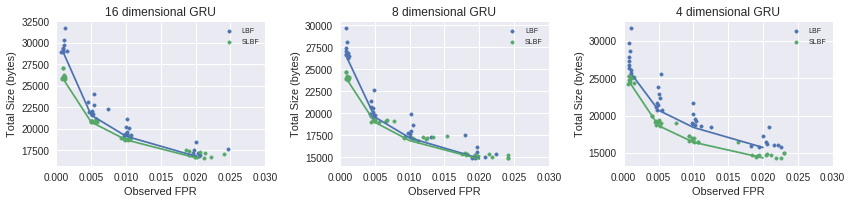

In [0]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  x_LBF = []
  y_LBF = []
  z_LBF = []
  x_SLBF = []
  y_SLBF = []
  z_SLBF = []
  for j1 in range(true_fpr_LBF[i].shape[1]):
    for j0 in range(true_fpr_LBF[i].shape[0]):
      x_LBF += [true_fpr_LBF[i].iloc[j0,j1]]
      y_LBF += [sizes_LBF[i].iloc[j0,j1]]
    z_LBF += [min(sizes_LBF[i].iloc[:,j1])]
  
  for j1 in range(true_fpr_SLBF[i].shape[1]):
    for j0 in range(true_fpr_SLBF[i].shape[0]):
      if(true_fpr_SLBF[i].index[j0] >= 1.):
        x_SLBF += [true_fpr_SLBF[i].iloc[j0,j1]]
        y_SLBF += [sizes_SLBF[i].iloc[j0,j1]]
    z_SLBF += [min(sizes_SLBF[i].dropna().iloc[:,j1])]
  ax[i].scatter(x_LBF,y_LBF, label = 'LBF', marker='.')
  ax[i].scatter(x_SLBF,y_SLBF, label = 'SLBF', marker='.')
  ax[i].plot(true_fpr_LBF[i].columns,z_LBF)
  ax[i].plot(true_fpr_SLBF[i].columns,z_SLBF)
  ax[i].set_title(str(h_sizes[i])+" dimensional GRU")
  ax[i].set_xlabel("Observed FPR")
  ax[i].set_ylabel("Total Size (bytes)")
  ax[i].set_xlim(left=0, right=0.03)
  ax[i].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"comparison_size_min.png")